In [1]:
import pandas as pd
import numpy as np
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import itertools
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mpl_toolkits.basemap import Basemap

/Users/RyanSampana/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/RyanSampana/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
bighead_carp = pd.read_excel('./data/carp_plus/Bighead-Carp-.xls')
grass_carp = pd.read_excel('./data/carp_plus/Grass-Carp-.xls')
common_carp = pd.read_excel('./data/carp_plus/Common-Carp3.xls')
silver_carp = pd.read_excel('./data/carp_plus/Silver-Carp.xls')
great_lakes = pd.read_excel('./data/carps_2/great-lakes-watershed-data.xls')
salmon = pd.read_excel('./data/carp_plus/Salmon-data.xls')

# we remove the tail end of the dataframes since these have (Latitude,Longidtude) = (0.0,0.0)
bighead_carp = bighead_carp[0:1437]
common_carp = common_carp[0:45032]
grass_carp = grass_carp[0:2268]
silver_carp = silver_carp[0:2300]

# add labels 1 for prescence 0 for abscence
bighead_carp['status'] = np.ones(len(bighead_carp))
common_carp['status'] = np.ones(len(common_carp))
grass_carp['status'] = np.ones(len(grass_carp))
silver_carp['status'] = np.ones(len(silver_carp))
salmon['status'] = np.zeros(len(salmon))

# salmon cleaning
salmon['decimalLatitude'] = salmon['POINT_Y']
salmon['decimalLongitude'] = salmon['POINT_X']
salmon = salmon.sample(frac=1).reset_index(drop=True)

# clustering 
from sklearn.cluster import KMeans
carp_list = [bighead_carp,grass_carp,silver_carp]
carp_names = ['bighead_carp','grass_carp','silver_carp']

silver_carp_cluster = silver_carp[['decimalLatitude','decimalLongitude']]
clusters = KMeans(n_clusters=20,n_init=20,n_jobs=4).fit(silver_carp_cluster).predict(silver_carp_cluster)
silver_carp['kmeans'] = clusters

for cluster in np.unique(silver_carp['kmeans']):
    print len(silver_carp[silver_carp['kmeans']==cluster])

311
304
1
33
46
66
2
57
423
74
23
3
28
40
129
67
12
21
652
8


# amount of plankton and presence of carp
cluster carp, then for each cluster-->, for each of the clusters, take earliest and last date... create new table of new monthly data of (sighting or not).

join carp and plankton data, if cell empty for plankton we interpolate. between previous month and next nonth. 
lets assume 

In [4]:
salmon.columns

Index([                      u'OBJECTID',                   u'FID_glwsheds',
                                 u'AREA',                      u'PERIMETER',
                             u'UNITNAME',                      u'LAKEBASIN',
                               u'SUBDIV',                      u'SUBSUBDIV',
                           u'SUBDIVNAME',                      u'NOMSUBDIV',
                                  u'HUC',                          u'BASIN',
                               u'REGION',                      u'SUBREGION',
                             u'ACCTUNIT',                      u'HYDROUNIT',
       u'FID_Stream_intersection_points',                       u'ORIG_FID',
                                u'arcid',                      u'grid_code',
                            u'from_node',                        u'to_node',
                              u'POINT_X',                        u'POINT_Y',
                                u'Slope',                  u'FlowAcc_Flow1',

In [5]:
len(salmon)

980

In [6]:
# data combination
list_of_features = ['decimalLatitude','decimalLongitude','Slope','FlowAcc_Flow1','FlowDir',
                       'May_Mean_Temp1','May_Mean_Precip1','StreamO_over1','status']

frames = [silver_carp[list_of_features],salmon[list_of_features]]

data = pd.concat(frames)
cut = 6 # this is the index of the we pick a cut that will roughly give us 50/50

# separate train
X_train = silver_carp[silver_carp['kmeans'] <= cut]
X_train = pd.concat([X_train[list_of_features],salmon[list_of_features].iloc[0:len(salmon)/2]])
y_train = X_train['status']
y_train = np.array(y_train)
X_train = X_train[['Slope','FlowAcc_Flow1','FlowDir','May_Mean_Temp1','StreamO_over1','May_Mean_Precip1']]
X_train = np.array(X_train)
print "len of train", len(X_train)
X_train = preprocessing.Imputer(strategy='mean').fit_transform(X_train)


# separate test
X_test = silver_carp[silver_carp['kmeans'] > cut]
X_test = pd.concat([X_test[list_of_features],salmon[list_of_features].iloc[len(salmon)/2:]])
y_test = X_test['status']
y_test = np.array(y_test)
X_test = X_test[['Slope','FlowAcc_Flow1','FlowDir','May_Mean_Temp1','StreamO_over1','May_Mean_Precip1']]
X_test = np.array(X_test)
X_test = preprocessing.Imputer(strategy='mean').fit_transform(X_test)
print "len of test", len(X_test)
# remove any NaN values 
# data[pd.isnull(data).any(axis=1)]
f_data = pd.DataFrame(data).fillna(value = 0.0)

# f_data = pd.DataFrame.dropna(data)
# X = data[pd.isnull(data).any(axis=1)]
# Y = pd.DataFrame(X).fillna(value=0.0)

# load data
# X = f_data[['Slope',
#             'FlowDir',
#             'FlowAcc_Flow1',
#             'May_Mean_Precip1',
#             'May_Mean_Temp1']]
# X = np.array(X)
# Y = f_data['status']
# Y = np.array(Y)
# class_names = ['abscence','prescence']

# Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.3 , random_state=1337)

len of train 1253
len of test 2027


In [7]:
bighead_carp.columns

Index([        u'OBJECTID',             u'key_',  u'decimalLatitude',
       u'decimalLongitude',        u'namer_dem',          u'FlowDir',
          u'FlowAcc_Flow1',            u'Slope',   u'May_Mean_Temp1',
       u'May_Mean_Precip1',    u'StreamO_over1',           u'status'],
      dtype='object')

0.919092254563
roc_auc 0.981073652623


<IPython.core.display.Javascript object>


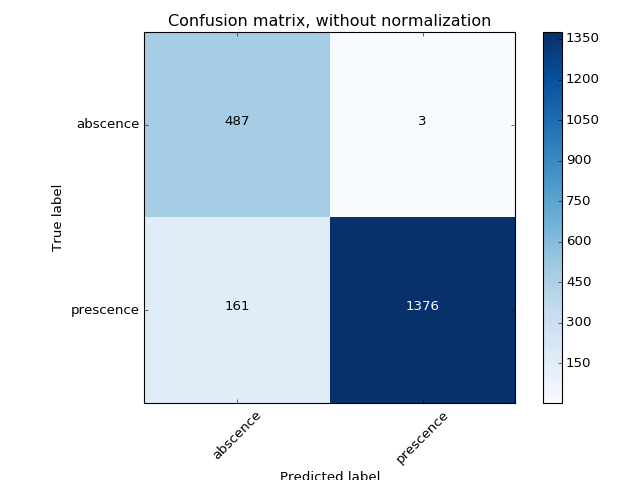

Confusion matrix, without normalization
[[ 487    3]
 [ 161 1376]]


<IPython.core.display.Javascript object>


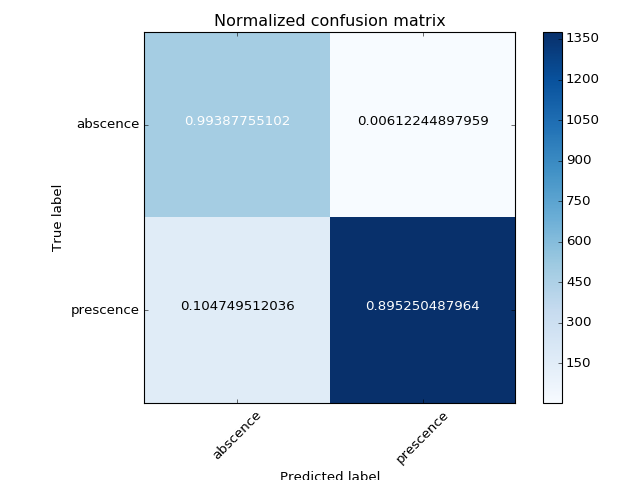

Normalized confusion matrix
[[ 0.99  0.01]
 [ 0.1   0.9 ]]


In [9]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
y_pred = clf.fit(X_train,y_train).predict(X_test)
y_score = clf.fit(X_train,y_train).predict_proba(X_test)
print accuracy_score(y_pred=y_pred,y_true=y_test)
class_names = ['abscence','prescence']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# ROC stuff
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(y_true=y_test,y_score=y_score[:,1])
roc_auc = auc(fpr, tpr)
print "roc_auc", roc_auc

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

0.758263443513


<IPython.core.display.Javascript object>


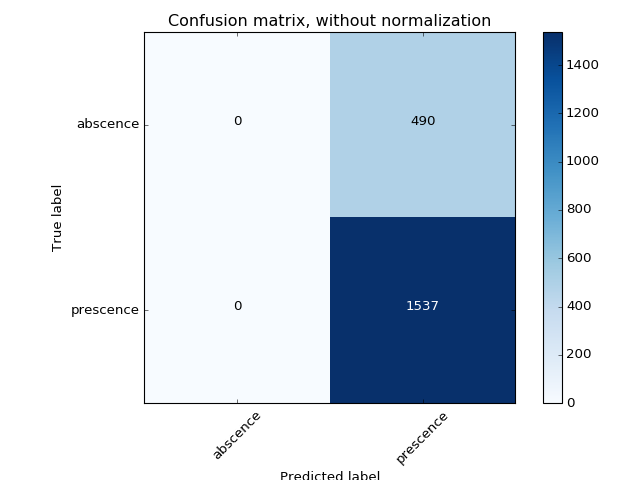

Confusion matrix, without normalization
[[   0  490]
 [   0 1537]]


<IPython.core.display.Javascript object>


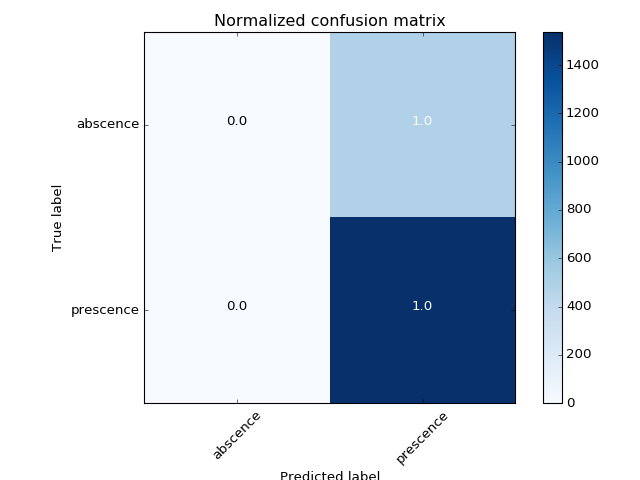

Normalized confusion matrix
[[ 0.  1.]
 [ 0.  1.]]


In [10]:
# what a out an SVM classifier
clf = SVC(C=0.1, kernel='rbf')
y_pred = clf.fit(X_train,y_train).predict(X_test)
print accuracy_score(y_pred=y_pred,y_true=y_test)
class_names = ['abscence','prescence']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# maybe try a bag of svms?

# Lets switch the test train sets

In [ ]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
y_pred = clf.fit(X_test,y_test).predict(X_train)
print accuracy_score(y_pred=y_pred,y_true=y_train)
class_names = ['abscence','prescence']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_train, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# let see where the data is clustered

In [ ]:
plt.figure()
for cluster in np.unique(silver_carp[['kmeans']]):
    group = silver_carp[silver_carp['kmeans'] == cluster]
    if cluster == 1:
        plt.plot(group['decimalLongitude'],group['decimalLatitude'],label=str(cluster),marker='x',linewidth=0)
        pass 
    else:
        plt.plot(group['decimalLongitude'],group['decimalLatitude'],label=str(cluster),marker='.',linewidth=0)
        pass 
    
plt.plot(salmon['decimalLongitude'].iloc[0:len(salmon)/2],salmon['decimalLatitude'].iloc[0:len(salmon)/2],label="salmon",marker='^',linewidth=0)
plt.plot(salmon['decimalLongitude'].iloc[len(salmon)/2:],salmon['decimalLatitude'].iloc[len(salmon)/2:],label="salmon",marker='*',linewidth=0)
plt.legend(loc='best')
plt.show()
for cluster in np.unique(silver_carp['kmeans']):
    print cluster,len(silver_carp[silver_carp['kmeans']==cluster])

# Maybe scaling the data will help when doing SVM

In [ ]:
from sklearn.preprocessing import scale
# split through the middle
X_test = f_data[f_data['decimalLatitude'] >= 42.0]
y_test = X_test['status']
X_test = X_test[['Slope',
            'FlowAcc_Flow1',
                 'FlowDir',
            'May_Mean_Precip1',
            'May_Mean_Temp1']]
X_test = np.array(X_test)
X_test = scale(X_test)

X_train = f_data[f_data['decimalLatitude'] <= 42.0]                
y_train = np.array(X_train['status'])
X_train = X_train[['Slope',
            'FlowAcc_Flow1',
                   'FlowDir',
            'May_Mean_Precip1',
            'May_Mean_Temp1']]  
X_train = np.array(X_train)
X_train = scale(X_train)

class_names = ['abscence','prescence']

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
y_pred = clf.fit(X_train,y_train).predict(X_test)
accuracy_score(y_pred=y_pred,y_true=y_test)
class_names = ['abscence','prescence']

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
print cnf_matrix
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')

plt.show()


In [ ]:
%%bash
cd ./data/carp_plus/
ls